**load and Process data**

In [ ]:
!rm -rf hand_gesture_dataset

In [ ]:
!rm -rf split_hand_gesture_dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split

# Unzip the dataset
dataset_path = "hand_gesture_dataset.zip"
dataset_dir = "hand_gesture_dataset"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)


In [ ]:
# Define paths
output_base_dir = "split_hand_gesture_dataset"
train_dir = os.path.join(output_base_dir, "train")
val_dir = os.path.join(output_base_dir, "val")
test_dir = os.path.join(output_base_dir, "test")
dataset_dir = "hand_gesture_dataset/hand_gesture_dataset"

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Parameters
img_size = (128, 128)
batch_size = 32

# Split dataset into train and validation sets
classes = ["fist", "five", "thumbsup", "thumbsdown"]

for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)

    train_val_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
    train_images, val_images = train_test_split(train_val_images, test_size=0.2, random_state=42)

    # Create class subdirectories in train, val, and test directories
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Move files to train, val, and test directories
    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_class_dir, img))

    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_class_dir, img))

    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_class_dir, img))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, rotation_range=30, zoom_range=0.2, horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", shuffle=False
)

print("Data preparation complete!")

Found 2880 images belonging to 4 classes.
Found 720 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Data preparation complete!


**Build the Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: fist, five, thumbsup, thumbsdown
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,836 (28.20 MB)

 Trainable params: 7,392,836 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

**Train the model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.5321 - loss: 1.7219 - val_accuracy: 0.9667 - val_loss: 0.1214
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9293 - loss: 0.2360 - val_accuracy: 0.9806 - val_loss: 0.0660
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9511 - loss: 0.1566 - val_accuracy: 0.9861 - val_loss: 0.0477
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9575 - loss: 0.1749 - val_accuracy: 0.9889 - val_loss: 0.0329
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9743 - loss: 0.0983 - val_accuracy: 0.9917 - val_loss: 0.0311
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9768 - loss: 0.0757 - val_accuracy: 0.9958 - val_loss: 0.0208
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9815 - loss: 0.0850 - val_accuracy: 0.9889 - val_loss: 0.0285
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9880 - loss: 0.0537 - val_accuracy: 0.9972 - val_loss: 0.016

**Evaluate the model**

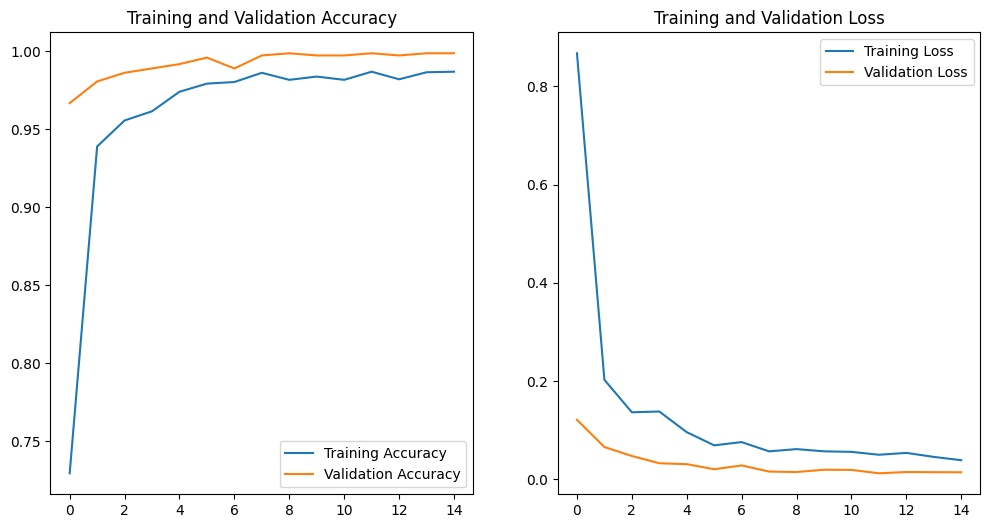

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_metrics(history)


**Evaluate Performances**

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step
Classification Report:
               precision    recall  f1-score   support

        fist       0.98      1.00      0.99       100
        five       1.00      1.00      1.00       100
  thumbsdown       1.00      1.00      1.00       100
    thumbsup       1.00      0.98      0.99       100

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400

Confusion Matrix:
 [[100   0   0   0]
 [  0 100   0   0]
 [  0   0 100   0]
 [  2   0   0  98]]


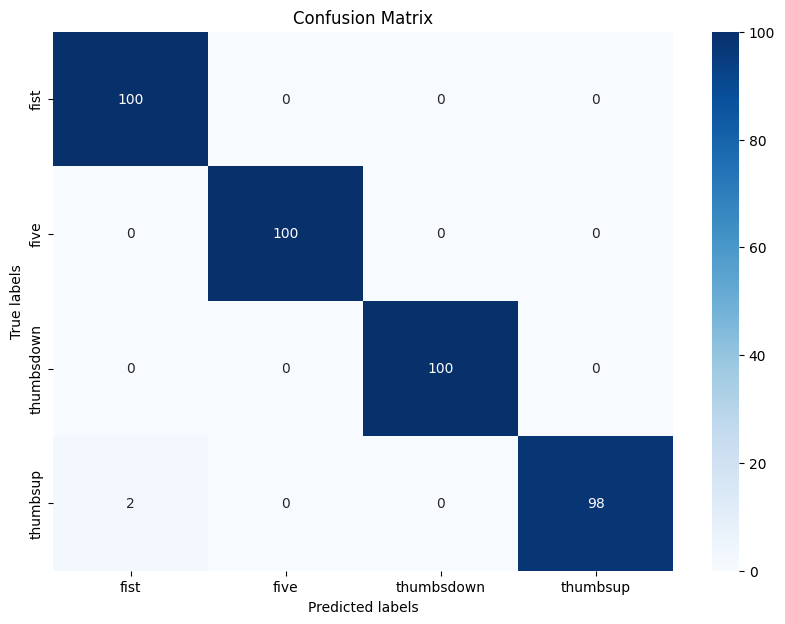

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate on test data
test_generator.reset()
predictions = model.predict(test_generator)  # Predict on test data
y_pred = np.argmax(predictions, axis=1)      # Predicted class indices
y_true = test_generator.classes              # True class indices

# Classification report
class_names = list(test_generator.class_indices.keys())  # Get class names from test_generator
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


**Save the model and lables**

In [ ]:
# Save model
model.save("hand_gesture_model.h5")

# Save class labels
import json

class_labels = train_generator.class_indices
with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)

print("Model and labels saved.")


Model and labels saved.


---  
**Sample Usage**

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 20.1 MB/s eta 0:00:00


---  
**Test with real data**

In [ ]:
# Unzip the dataset
dataset_path = "hand_gesture_dataset_test.zip"
dataset_dir = "hand_gesture_dataset_test"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

Found 400 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 523ms/step

Classification Report:
              precision    recall  f1-score   support

        fist       0.92      1.00      0.96       100
        five       1.00      0.93      0.96       100
  thumbsdown       1.00      0.97      0.98       100
    thumbsup       0.99      1.00      1.00       100

    accuracy                           0.97       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.97      0.98       400



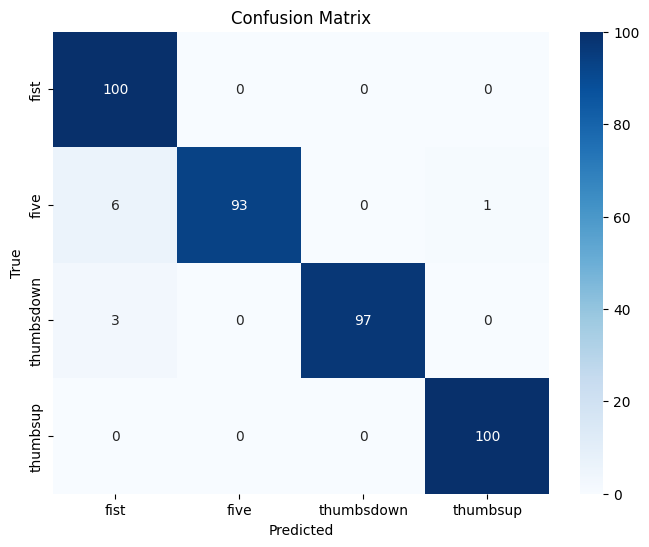


Overall Test Accuracy: 97.50%


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("hand_gesture_model.h5")

# Load class labels
with open("class_labels.json", "r") as f:
    class_labels = json.load(f)
class_labels = {int(v): k for k, v in class_labels.items()}

# Set the path to the labeled test dataset
test_dir = "hand_gesture_dataset_test/hand_gesture_dataset_test"

# Parameters
img_size = (128, 128)
batch_size = 32

# Data generator for the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Ensure labels align with predictions
)

# Predict on the test dataset
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Compute evaluation metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Overall accuracy
accuracy = np.sum(y_true == y_pred) / len(y_true)
print(f"\nOverall Test Accuracy: {accuracy:.2%}")


**Display some images with thier actual and predicted labels**

Found 400 images belonging to 4 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step


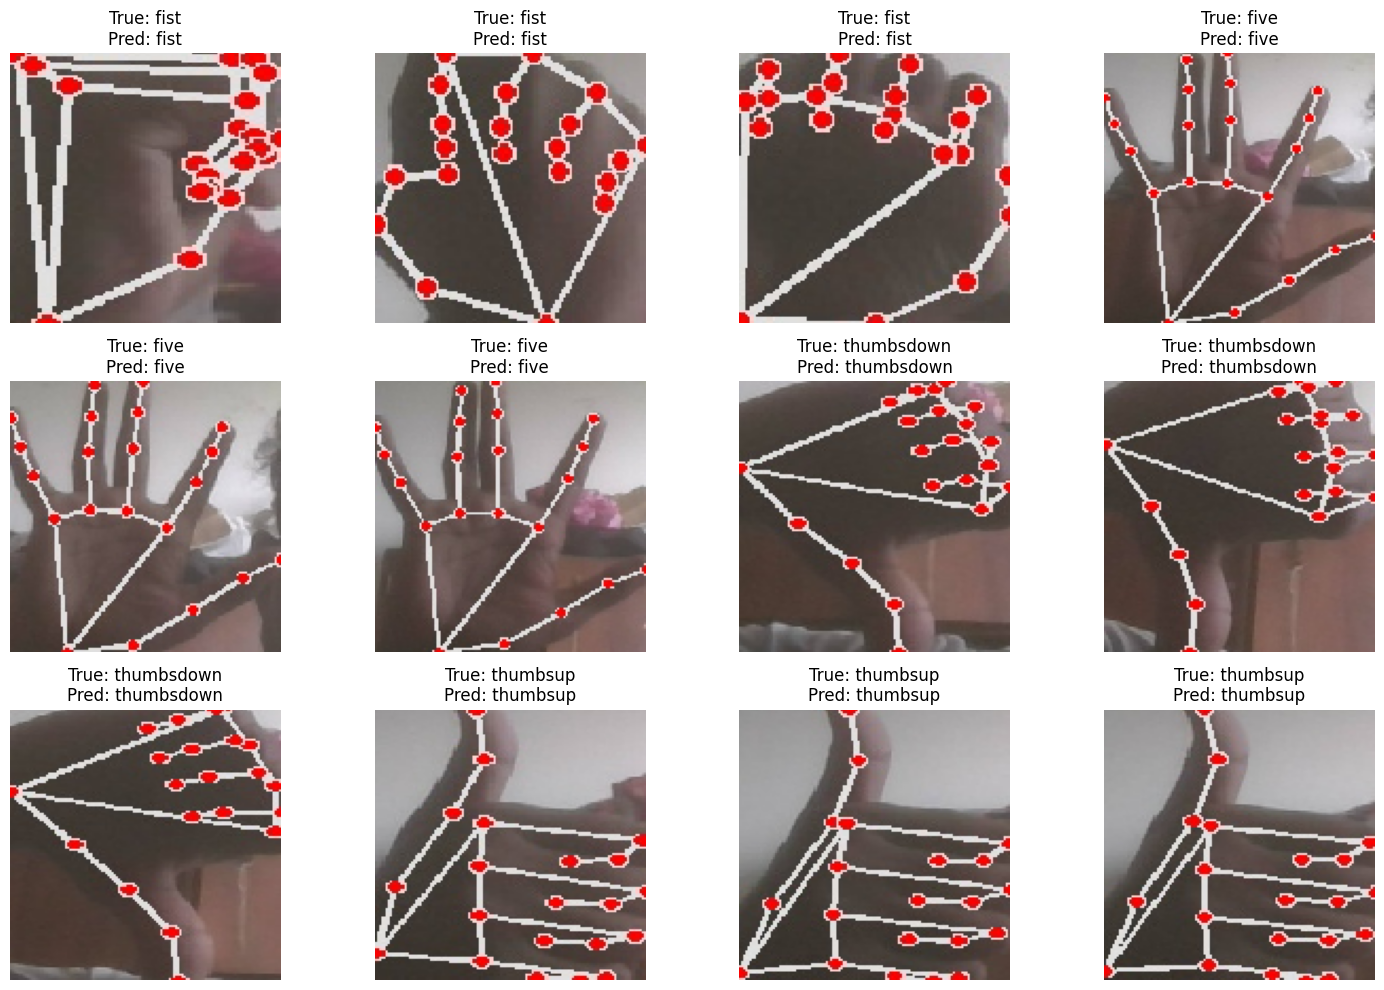

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import random

# Load the trained model
model = tf.keras.models.load_model("hand_gesture_model.h5")

# Load class labels
with open("class_labels.json", "r") as f:
    class_labels = json.load(f)
class_labels = {int(v): k for k, v in class_labels.items()}

# Set the path to the labeled test dataset
test_dir = "hand_gesture_dataset_test/hand_gesture_dataset_test"

# Parameters
img_size = (128, 128)
batch_size = 32

# Data generator for the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Ensure labels align with predictions
)

# Predict on the test dataset
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Function to display images with labels
def display_images_with_labels(generator, y_true, y_pred, class_labels, n=3):
    # Group images by class
    class_images = {i: [] for i in range(len(class_labels))}

    # Loop through the generator and group images by class
    for batch_idx in range(len(generator)):
        images, labels = generator[batch_idx]
        batch_y_true = y_true[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        batch_y_pred = y_pred[batch_idx * batch_size : (batch_idx + 1) * batch_size]

        # Group images by their true class
        for i, image in enumerate(images):
            true_class = batch_y_true[i]
            class_images[true_class].append((image, true_class, batch_y_pred[i]))

    # Select 3 random images for each class and display them
    selected_images = []
    for cls in class_images:
        random_images = random.sample(class_images[cls], min(n, len(class_images[cls])))
        selected_images.extend(random_images)

    # Plot the images
    num_classes = len(class_labels)
    fig, axes = plt.subplots(nrows=n, ncols=num_classes, figsize=(15, 10))
    axes = axes.ravel()

    for i, (image, true_label, predicted_label) in enumerate(selected_images):
        class_name_true = class_labels[true_label]
        class_name_pred = class_labels[predicted_label]
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"True: {class_name_true}\nPred: {class_name_pred}")

    plt.tight_layout()
    plt.show()

# Display images with true and predicted labels
display_images_with_labels(test_generator, y_true, y_pred, class_labels)


In [67]:
# prompt: download the hand_gesture_model.h5 into local

from google.colab import files
files.download('hand_gesture_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>